Data Description

* PassengerId - A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger   
  is travelling with and pp is their number within the group. People in a group are often family members, but not always.

* HomePlanet - The planet the passenger departed from, typically their planet of permanent residence.

* CryoSleep - Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage.  
  Passengers in cryosleep are confined to their cabins.
  
* Cabin - The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for 
  Port or S for Starboard.
  
* Destination - The planet the passenger will be debarking to.

* Age - The age of the passenger.

* VIP - Whether the passenger has paid for special VIP service during the voyage.

* RoomService, FoodCourt, ShoppingMall, Spa, VRDeck - Amount the passenger has billed at each of the Spaceship Titanic's 
  many luxury amenities.
  
* Name - The first and last names of the passenger.

* Transported - Whether the passenger was transported to another dimension. This is the target, the column you are trying 
  to predict.

In [2]:
!pip install xgboost

In [3]:
# Import all the tools needed

import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import sklearn
import seaborn as sns
import random

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import plot_roc_curve, roc_auc_score

In [4]:
df = pd.read_csv("data/train.csv")
df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


In [6]:
df.head().T

,0,1,2,3,4
PassengerId,0001_01,0002_01,0003_01,0003_02,0004_01
HomePlanet,Europa,Earth,Europa,Europa,Earth
CryoSleep,False,False,False,False,False
Cabin,B/0/P,F/0/S,A/0/S,A/0/S,F/1/S
Destination,TRAPPIST-1e,TRAPPIST-1e,TRAPPIST-1e,TRAPPIST-1e,TRAPPIST-1e
Age,39.0,24.0,58.0,33.0,16.0
VIP,False,False,True,False,False
RoomService,0.0,109.0,43.0,0.0,303.0
FoodCourt,0.0,9.0,3576.0,1283.0,70.0
ShoppingMall,0.0,25.0,0.0,371.0,151.0


In [7]:
df[['Deck', 'Num', 'Side']] = df['Cabin'].str.split(pat = '/', expand=True)
df.head().T

,0,1,2,3,4
PassengerId,0001_01,0002_01,0003_01,0003_02,0004_01
HomePlanet,Europa,Earth,Europa,Europa,Earth
CryoSleep,False,False,False,False,False
Cabin,B/0/P,F/0/S,A/0/S,A/0/S,F/1/S
Destination,TRAPPIST-1e,TRAPPIST-1e,TRAPPIST-1e,TRAPPIST-1e,TRAPPIST-1e
Age,39.0,24.0,58.0,33.0,16.0
VIP,False,False,True,False,False
RoomService,0.0,109.0,43.0,0.0,303.0
FoodCourt,0.0,9.0,3576.0,1283.0,70.0
ShoppingMall,0.0,25.0,0.0,371.0,151.0


In [8]:
df.drop(["Cabin", "RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"], axis = 1, inplace = True)

In [9]:
df.head().T

,0,1,2,3,4
PassengerId,0001_01,0002_01,0003_01,0003_02,0004_01
HomePlanet,Europa,Earth,Europa,Europa,Earth
CryoSleep,False,False,False,False,False
Destination,TRAPPIST-1e,TRAPPIST-1e,TRAPPIST-1e,TRAPPIST-1e,TRAPPIST-1e
Age,39.0,24.0,58.0,33.0,16.0
VIP,False,False,True,False,False
Name,Maham Ofracculy,Juanna Vines,Altark Susent,Solam Susent,Willy Santantines
Transported,False,True,False,False,True
Deck,B,F,A,A,F
Num,0,0,0,0,1


In [10]:
df.describe()

,Age
count,8514.000000
mean,28.827930
std,14.489021
min,0.000000
25%,19.000000
50%,27.000000
75%,38.000000
max,79.000000


In [11]:
# Converting CryoSleep
df.rename({"CryoSleep" : "Cryosleep"}, axis = 1, inplace = True)
df["new_column"] = pd.get_dummies(df["Cryosleep"], drop_first = True)
df.rename({"new_column" : "CryoSleep"}, axis = 1, inplace = True)
df.drop("Cryosleep", axis = 1, inplace = True)

In [12]:
# Converting VIP
df.rename({"VIP" : "vip"}, axis = 1, inplace = True)
df["new_column"] = pd.get_dummies(df["vip"], drop_first = True)
df.rename({"new_column" : "VIP"}, axis = 1, inplace = True)
df.drop("vip", axis = 1, inplace = True)

In [13]:
# Converting CryoSleep
df.rename({"Transported" : "_Transported"}, axis = 1, inplace = True)
df["new_column"] = pd.get_dummies(df["_Transported"], drop_first = True)
df.rename({"new_column" : "Transported"}, axis = 1, inplace = True)
df.drop("_Transported", axis = 1, inplace = True)

In [14]:
# Checking missing data
df.isna().sum()

PassengerId      0
HomePlanet     201
Destination    182
Age            179
Name           200
Deck           199
Num            199
Side           199
CryoSleep        0
VIP              0
Transported      0
dtype: int64

Filling the empty numeric with median and assigning non-numeric rows with codes.

In [15]:
# Filling numeric data
for label, values in df.items():
    if pd.api.types.is_numeric_dtype(values):
        if pd.isnull(values).sum():
            df[label] = values.fillna(values.median())

In [16]:
# Filling non-numeric data
for label, values in df.items():
    if not pd.api.types.is_numeric_dtype(values):
        if pd.isnull(values).sum():
            df[label] = pd.Categorical(values).codes + 1

In [17]:
df.isna().sum()

PassengerId    0
HomePlanet     0
Destination    0
Age            0
Name           0
Deck           0
Num            0
Side           0
CryoSleep      0
VIP            0
Transported    0
dtype: int64

No missing values.

In [18]:
df.dtypes

PassengerId     object
HomePlanet        int8
Destination       int8
Age            float64
Name             int16
Deck              int8
Num              int16
Side              int8
CryoSleep        uint8
VIP              uint8
Transported      uint8
dtype: object

In [19]:
df["PassengerId"] = df["PassengerId"].astype(int)

In [20]:
df["Transported"].unique()

array([0, 1], dtype=uint8)

In [21]:
df["Transported"].value_counts()

1    4378
0    4315
Name: Transported, dtype: int64

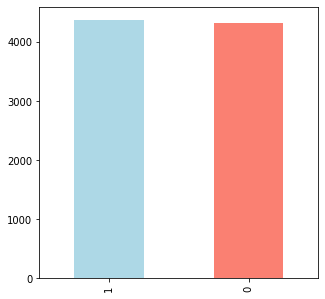

In [22]:
df["Transported"].value_counts().plot(figsize = (5,5), kind = "bar", color = ["lightblue", "salmon"]);

This means half of the passengers were Transported and the other half weren't transported. 

In [23]:
df["CryoSleep"].value_counts()

0    5656
1    3037
Name: CryoSleep, dtype: int64

In [24]:
pd.crosstab(df.Transported, df.CryoSleep)

CryoSleep,0,1
Transported,,
0,3761,554
1,1895,2483


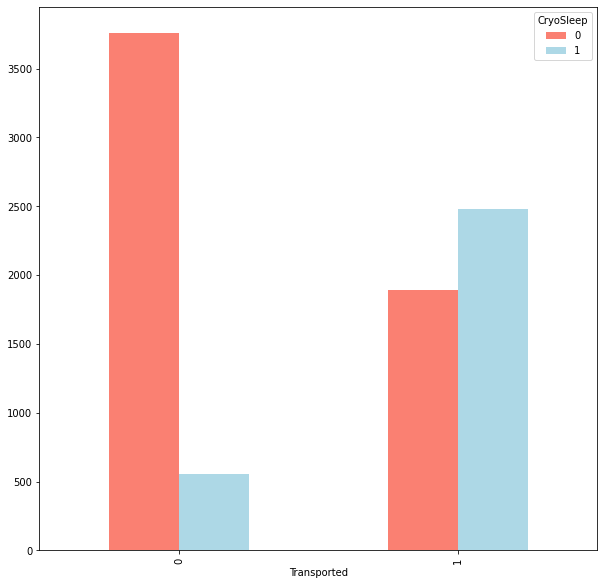

In [25]:
# Visuzlizing it
pd.crosstab(df.Transported, df.CryoSleep).plot(figsize = (10, 10), kind = "bar", color = ["salmon", "lightblue"]);

In [26]:
len(df)

8693

There is roughly a 22% chance that people who were not in CryoSleep were transported to another planet, whereas there is a 28.5% chance that the people who were in cryoSleep were also transported.

Based on our existing data, there is a 43% chance that the people who were not in Cryosleep weren't transported.

In [27]:
df["Age"].unique()

array([39., 24., 58., 33., 16., 44., 26., 28., 35., 14., 34., 45., 32.,
       48., 31., 27.,  0.,  1., 49., 29., 10.,  7., 21., 62., 15., 43.,
       47.,  2., 20., 23., 30., 17., 55.,  4., 19., 56., 25., 38., 36.,
       22., 18., 42., 37., 13.,  8., 40.,  3., 54.,  9.,  6., 64., 67.,
       61., 50., 41., 57., 11., 52., 51., 46., 60., 63., 59.,  5., 79.,
       68., 74., 12., 53., 65., 71., 75., 70., 76., 78., 73., 66., 69.,
       72., 77.])

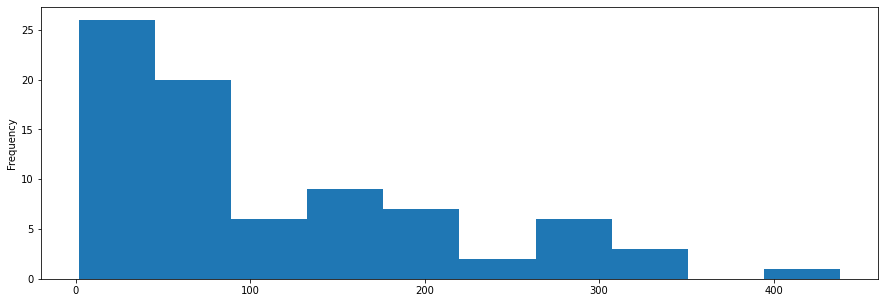

In [28]:
df["Age"].value_counts().plot(figsize = (15, 5), kind = "hist");

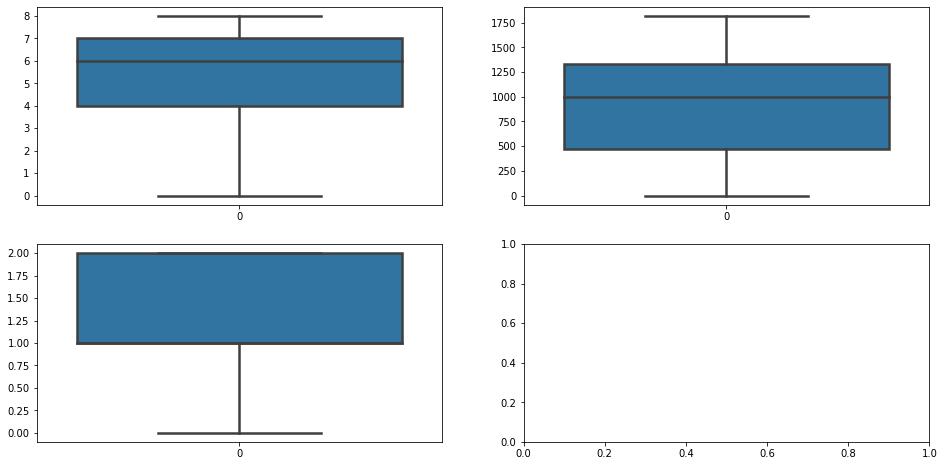

In [29]:
fig, axs = plt.subplots(2, 2, figsize=(16,8))

ax = sns.boxplot(ax = axs[0,0], data = df["Deck"], palette="tab10", linewidth=2.5)

ax = sns.boxplot(ax = axs[0,1], data = df["Num"], palette="tab10", linewidth=2.5)

ax = sns.boxplot(ax = axs[1,0], data = df["Side"], palette="tab10", linewidth=2.5)

plt.show();

Our data is ready for modelling.

## Modelling

In [30]:
# Split data into x and y
x = df.drop("Transported", axis = 1)
y = df["Transported"]

# Set random seed
np.random.seed(42)

# Split data into train and valid
x_train, x_valid, y_train, y_valid = train_test_split(x, y, test_size = 0.2)

In [31]:
x_train.shape, x_valid.shape, y_train.shape, y_valid.shape

((6954, 10), (1739, 10), (6954,), (1739,))

Now we've got our data into training and validation sets. Let's build a model.

We are going to train our data in these models:

* Random Forest Classifier
* Logistic Regression
* KNeighbors Classifier
* GaussianNB
* XGBClassifier

In [32]:
models = {"Random Forest Classifier" : RandomForestClassifier(),
          "Logistic Regression" : LogisticRegression(),
          "KNeighbors Classifier" : KNeighborsClassifier(),
          "GaussianNB" : GaussianNB(),
          "XGBClassifier" : XGBClassifier(),
          "SVC" : SVC(),
          "Decision Tree Classifier" : DecisionTreeClassifier()}

In [33]:
def fit_and_score (models, x_train, x_valid, y_train, y_valid):
    """
    Fits and evaluates the given models.
    """
    
    # Set random seed
    np.random.seed(42)
    
    # Set empty dictionary
    model_scores = {}
    
    # Loop through models
    for names, model in models.items():
        
        # Fit the model
        model.fit(x_train, y_train)
           
        # Evaluate the model and append the score to model_scores
        model_scores[names] = model.score(x_valid, y_valid)
        
    return model_scores

In [34]:
model_score = fit_and_score(models = models,
                             x_train = x_train,
                             x_valid = x_valid,
                             y_train = y_train,
                             y_valid = y_valid)
model_score

{'Random Forest Classifier': 0.7377803335250144,
 'Logistic Regression': 0.6060954571592869,
 'KNeighbors Classifier': 0.5296147211040828,
 'GaussianNB': 0.5612420931569868,
 'XGBClassifier': 0.726279470960322,
 'SVC': 0.547441058079356,
 'Decision Tree Classifier': 0.6687751581368603}

In [35]:
model_table = pd.DataFrame(model_score, index = ["Scores"])
model_table.T

,Scores
Random Forest Classifier,0.737780
Logistic Regression,0.606095
KNeighbors Classifier,0.529615
GaussianNB,0.561242
XGBClassifier,0.726279
SVC,0.547441
Decision Tree Classifier,0.668775


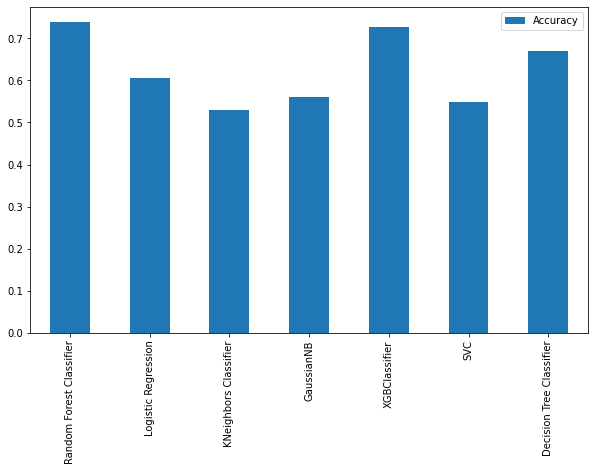

In [36]:
model_compare = pd.DataFrame(model_score, index = ["Accuracy"])
model_compare.T.plot.bar(figsize = (10, 6));

We will go forward with `RandomForestClassifier()` and `XGBClassifier()` to increase the scores by tuning hyperparameters.

In [37]:
# Create a hyperparameter grid for RandomForestClassifier()
clf_grid = {'n_estimators': np.arange(100, 1000, 200),
            'max_depth': [3, 5, None],
            'max_features': ['sqrt'],
            'min_samples_leaf': np.arange(2, 20, 2),
            'min_samples_split': np.arange(2, 10, 2)}

# Let's try GridSearchCV on RandomForestClassifier()
clf_rs = RandomizedSearchCV(estimator = RandomForestClassifier(), 
                      param_distributions = clf_grid, 
                      cv = 3, 
                      n_iter = 50,
                      verbose = 2,
                      n_jobs = -1)

In [38]:
%%time
clf_rs.fit(x_train, y_train)

Fitting 3 folds for each of 50 candidates, totalling 150 fits
CPU times: user 2.51 s, sys: 169 ms, total: 2.68 s
Wall time: 1min 6s


RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=50,
                   n_jobs=-1,
                   param_distributions={'max_depth': [3, 5, None],
                                        'max_features': ['sqrt'],
                                        'min_samples_leaf': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18]),
                                        'min_samples_split': array([2, 4, 6, 8]),
                                        'n_estimators': array([100, 300, 500, 700, 900])},
                   verbose=2)

In [39]:
clf_rs.best_params_

{'n_estimators': 300,
 'min_samples_split': 6,
 'min_samples_leaf': 14,
 'max_features': 'sqrt',
 'max_depth': None}

In [40]:
clf_rs.score(x_valid, y_valid)

0.7487061529614721

In [41]:
# Create a hyperparameter grid for RandomForestClassifier()
clf_grid = {'n_estimators': np.arange(400, 1000, 200),
            'max_depth': [None],
            'max_features': ['sqrt'],
            'min_samples_leaf': np.arange(10, 20, 2),
            'min_samples_split': np.arange(2, 10, 2)}

# Let's try GridSearchCV on RandomForestClassifier()
clf_gs = GridSearchCV(estimator = RandomForestClassifier(), 
                      param_grid = clf_grid, 
                      cv = 3, 
                      verbose = 2,
                      n_jobs = -1)

In [42]:
%%time
clf_gs.fit(x_train, y_train)

Fitting 3 folds for each of 60 candidates, totalling 180 fits
CPU times: user 6.28 s, sys: 68.9 ms, total: 6.35 s
Wall time: 1min 51s


GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [None], 'max_features': ['sqrt'],
                         'min_samples_leaf': array([10, 12, 14, 16, 18]),
                         'min_samples_split': array([2, 4, 6, 8]),
                         'n_estimators': array([400, 600, 800])},
             verbose=2)

In [43]:
clf_gs.best_params_

{'max_depth': None,
 'max_features': 'sqrt',
 'min_samples_leaf': 16,
 'min_samples_split': 6,
 'n_estimators': 800}

In [44]:
clf_gs.score(x_valid, y_valid)

0.7481311098332375

In [45]:
# Create a hyperparameter grid for XGBClassifier()

xg_NB_grid = {'n_estimators': np.arange(100, 1000, 100),
              'learning_rate': np.arange(0.01, 0.6, 0.50),
              'subsample': np.arange(0.3, 0.9, 0.1),
              'max_depth': [3, 4, 5, 6, 7, 8, 9],
              'colsample_bytree': np.arange(0.5, 0.9, 0.1),
              'min_child_weight': [1, 2, 3, 4]
             }

# Let's try RndomizedSearchCV on XGBClassifier
xg_NB_rs = RandomizedSearchCV(estimator = XGBClassifier(), 
                        param_distributions = xg_NB_grid,
                        error_score = 0,
                        cv = 30,
                        scoring = 'roc_auc',
                        verbose = 3, 
                        n_jobs = -1)

In [46]:
%%time
xg_NB_rs.fit(x_train, y_train)

Fitting 30 folds for each of 10 candidates, totalling 300 fits
[CV] END max_depth=3, max_features=sqrt, min_samples_leaf=12, min_samples_split=6, n_estimators=100; total time=   0.4s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=8, min_samples_split=2, n_estimators=700; total time=   2.8s
[CV] END max_depth=3, max_features=sqrt, min_samples_leaf=8, min_samples_split=8, n_estimators=500; total time=   1.7s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=2, min_samples_split=2, n_estimators=300; total time=   1.2s
[CV] END max_depth=3, max_features=sqrt, min_samples_leaf=2, min_samples_split=6, n_estimators=100; total time=   0.3s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=12, min_samples_split=6, n_estimators=100; total time=   0.6s
[CV] END max_depth=3, max_features=sqrt, min_samples_leaf=8, min_samples_split=8, n_estimators=700; total time=   2.3s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=18, min_samples_split=4, n_estimators=900

RandomizedSearchCV(cv=30, error_score=0,
                   estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, gamma=None,
                                           gpu_id=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate=Non...
                                           predictor=None, random_state=None,
                                           reg_alpha=None, reg_lambda=None, ...),
                   n_jobs=-1,
                   param_distributions={'colsample_bytree': array([0.5, 0.6, 0.7, 0.8]),
                                        'learning_rate': array([0.01, 0.51]),
                                        'max_depth': [3, 4, 5, 6, 7, 8, 9],
                                        'min_child_weight': [1, 2, 3, 4],
                                        'n_estimators': array([100, 200, 300, 400, 500, 600, 700, 800, 900]),
                                        'subsample': array([0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9])},
                   scoring='roc_auc', verbose=3)

In [47]:
xg_NB_rs.best_params_

{'subsample': 0.4,
 'n_estimators': 900,
 'min_child_weight': 1,
 'max_depth': 5,
 'learning_rate': 0.01,
 'colsample_bytree': 0.7}

In [48]:
xg_NB_rs.score(x_valid, y_valid)

0.8162583106468878

In [49]:
# Create a hyperparameter grid for XGBClassifier()

xg_NB_grid = {'n_estimators': np.arange(100, 500, 100),
              'learning_rate': np.arange(0.01, 0.5, 0.50),
              'subsample': np.arange(0.3, 0.6, 0.1),
              'max_depth': [6, 7, 8, 9],
              'colsample_bytree': np.arange(0.5, 0.7, 0.1),
              'min_child_weight': [1, 2, 3]}

# Let's try GridSearchCV on XGBClassifier
xg_NB_gs = GridSearchCV(estimator = XGBClassifier(), 
                        param_grid = xg_NB_grid,
                        error_score = 0,
                        scoring = 'roc_auc',
                        verbose = 3, 
                        n_jobs = -1)

In [50]:
%%time
xg_NB_gs.fit(x_train, y_train)

Fitting 5 folds for each of 288 candidates, totalling 1440 fits
[CV 8/30] END colsample_bytree=0.7, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=900, subsample=0.4;, score=0.819 total time=   5.0s
[CV 14/30] END colsample_bytree=0.7, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=900, subsample=0.4;, score=0.826 total time=   4.9s
[CV 20/30] END colsample_bytree=0.7, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=900, subsample=0.4;, score=0.819 total time=   5.0s
[CV 26/30] END colsample_bytree=0.7, learning_rate=0.01, max_depth=5, min_child_weight=1, n_estimators=900, subsample=0.4;, score=0.813 total time=   4.8s
[CV 2/30] END colsample_bytree=0.5, learning_rate=0.01, max_depth=9, min_child_weight=1, n_estimators=200, subsample=0.8000000000000003;, score=0.816 total time=   1.8s
[CV 8/30] END colsample_bytree=0.5, learning_rate=0.01, max_depth=9, min_child_weight=1, n_estimators=200, subsample=0.8000000000000003;, score=0.81

GridSearchCV(error_score=0,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     gamma=None, gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_bin=No...
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, reg_alpha=None,
                                     reg_lambda=None, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': array([0.5, 0.6]),
                         'learning_rate': array([0.01]),
                         'max_depth': [6, 7, 8, 9],
                         'min_child_weight': [1, 2, 3],
                         'n_estimators': array([100, 200, 300, 400]),
                         'subsample': array([0.3, 0.4, 0.5])},
             scoring='roc_auc', verbose=3)

In [51]:
xg_NB_gs.best_params_

{'colsample_bytree': 0.5,
 'learning_rate': 0.01,
 'max_depth': 6,
 'min_child_weight': 2,
 'n_estimators': 400,
 'subsample': 0.5}

In [52]:
xg_NB_gs.score(x_valid, y_valid)

0.8175427735403291

/usr/local/lib/python3.9/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


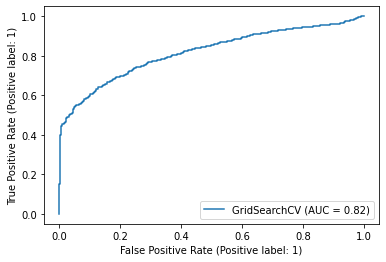

In [53]:
# Plot ROC Curve and calcualte AUC metric
plot_roc_curve (xg_NB_gs, x_valid, y_valid)

## Predictions on Test Dataset

In [54]:
df_test = pd.read_csv("data/test.csv")
df_test.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,0013_01,Earth,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning
1,0018_01,Earth,False,F/4/S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers
2,0019_01,Europa,True,C/0/S,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus
3,0021_01,Europa,False,C/1/S,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0,Meratz Caltilter
4,0023_01,Earth,False,F/5/S,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0,Brence Harperez


Before we make predictions we need to make sure that we make all the changes in our test data that we made in our training data.

In [55]:
def preprocess_data(df):
    """
    Performs transformation on df_test and returns transformed test data.
    """
    
        # Splitting `Cabin` column into 3 different columns
    df[['Deck', 'Num', 'Side']] = df['Cabin'].str.split(pat = '/', expand=True)
    df.head().T


    # Drooping some columns 
    df.drop(["Cabin", "RoomService", "FoodCourt", "ShoppingMall", "Spa", "VRDeck"], axis = 1, inplace = True) 

    # Converting CryoSleep
    df.rename({"CryoSleep" : "Cryosleep"}, axis = 1, inplace = True)
    df["new_column"] = pd.get_dummies(df["Cryosleep"], drop_first = True)
    df.rename({"new_column" : "CryoSleep"}, axis = 1, inplace = True)
    df.drop("Cryosleep", axis = 1, inplace = True)

    # Converting VIP
    df.rename({"VIP" : "vip"}, axis = 1, inplace = True)
    df["new_column"] = pd.get_dummies(df["vip"], drop_first = True)
    df.rename({"new_column" : "VIP"}, axis = 1, inplace = True)
    df.drop("vip", axis = 1, inplace = True)

    df["PassengerId"] = df["PassengerId"].astype(int)


    # Filling the empty numeric-rows with median and assigning non-numeric rows with codes

    # Filling numeric data
    for label, values in df.items():
        if pd.api.types.is_numeric_dtype(values):
            if pd.isnull(values).sum():
                df[label] = values.fillna(values.median())

    # Filling non-numeric data
    for label, values in df.items():
        if not pd.api.types.is_numeric_dtype(values):
            if pd.isnull(values).sum():
                df[label] = pd.Categorical(values).codes + 1 
                
    
                
    return df

In [56]:
# Preprocess test data
df_test = preprocess_data(df_test)
df_test.head()

,PassengerId,HomePlanet,Destination,Age,Name,Deck,Num,Side,CryoSleep,VIP
0,1301,1,3,27.0,2913,7,821,2,1,0
1,1801,1,3,19.0,2407,6,928,2,0,0
2,1901,2,1,31.0,3377,3,1,2,1,0
3,2101,2,3,38.0,2712,3,2,2,0,0
4,2301,1,3,20.0,669,6,1030,2,0,0


In [57]:
# Making predictions on updated data
test_preds = xg_NB_gs.predict(df_test)
test_preds

array([1, 0, 1, ..., 1, 1, 1])

In [58]:
# Kaggle Predictions
df_preds = pd.DataFrame()
df_preds["PassengerID"] = df_test["PassengerId"]
df_preds["Trnasported"] = test_preds
df_preds.head()

,PassengerID,Trnasported
0,1301,1
1,1801,0
2,1901,1
3,2101,1
4,2301,0


In [59]:
# Export prediction data
df_preds.to_csv("data/test-predictions.csv", index = False)

[CV 2/5] END colsample_bytree=0.6, learning_rate=0.01, max_depth=9, min_child_weight=2, n_estimators=100, subsample=0.4;, score=0.810 total time=   0.8s
[CV 2/5] END colsample_bytree=0.6, learning_rate=0.01, max_depth=9, min_child_weight=2, n_estimators=100, subsample=0.5;, score=0.807 total time=   0.9s
[CV 5/5] END colsample_bytree=0.6, learning_rate=0.01, max_depth=9, min_child_weight=2, n_estimators=200, subsample=0.3;, score=0.811 total time=   1.4s
[CV 1/5] END colsample_bytree=0.6, learning_rate=0.01, max_depth=9, min_child_weight=2, n_estimators=200, subsample=0.5;, score=0.806 total time=   1.7s
[CV 2/5] END colsample_bytree=0.6, learning_rate=0.01, max_depth=9, min_child_weight=2, n_estimators=300, subsample=0.3;, score=0.805 total time=   2.1s
[CV 3/5] END colsample_bytree=0.6, learning_rate=0.01, max_depth=9, min_child_weight=2, n_estimators=300, subsample=0.4;, score=0.816 total time=   2.2s
[CV 3/5] END colsample_bytree=0.6, learning_rate=0.01, max_depth=9, min_child_weig